# "An RL Approach for Inventory Management (Part 8)"

> Tabular Temporal-Difference Prediction
- toc: true
- branch: master
- badges: false
- comments: true
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2
- image: images/InventoryManagement8.png
- categories: [Inventory_Management,   Markov_Decision_Process,   TD]
- show_tags: true

In [2]:
# hide
# based on 0^td_simple_inventory_mrp_KE.ipynb

## 1 Overview of the Reinforcement Learning Approach

So far, we always had a *model* for the environment. This model came in the form of transition probabilities. It is often the case in the real world that we do not have these probabilties. We simply get individual experiences of next state and reward, given we take a specific action in a specific state. However, we still need a way to obtain the optimal value function or the optimal policy. There are algorithms available for this need. We have now entered the subfield of Reinforcement Learning. When we have a model (as in previous parts) the subfield is called Dynamic Programming or Approximate Dynamic Programming.

Note that we can use Reinforcement Learning even if we may have the option to obtain a model. Sometimes the state space is so large that obtaining a model is hard or the computational aspects become intractable. 

## 2 RL for Prediction

Let us repeat some points related to *prediction*:
- *prediction* is the problem of estimating the *value function* of an MDP given a policy $\pi$
- the equivalent problem is to estimate the value function of the $\pi$-implied MRP

In this project we choose to work with MRPs, rather than MDPs, depending on the latter point. The relationship with the MRP environment is such that the:
- Environment is available as an interface that serves up individual experiences of (next state, reward), given a current state. Note the absence of an action.
- Environment might the *real* or *simulated*.

We define the agent's experience with the environment as follows:
  - *atomic experience*
    - agent receives a single experience of (next state, reward), given current state
  - *trace experience*
    - starting from state $S_0$, repeated interactions with the environment leading to a sequence of atomic experiences

The RL prediction problem is the estimate the value function, given a stream of atomic experiences or a stream of trace experiences.

An MRP's value function is:

$$
V(s) = \mathbb E[G_t|S_t=s]
$$

for all $s \in \mathcal N$, for all $t=0,1,2,...$

where the return $G_t$ for each $t=0,1,2,...$ is defined as:

$$
\begin{aligned}
G_t &= R_{t+1}+\gamma \cdot R_{t+2}+\gamma^2 \cdot R_{t+3}+... \\
&= \sum_{i=t+1}^\infty \gamma ^{i-t-1} \cdot R_i \\
&= R_{t+1}+\gamma \cdot G_{t+1}
\end{aligned}
$$

This infinite sum is true even if a trace experience terminates, say at $t=T$ ($S_T \in \mathcal T$) because we take $R_i=0$ for all $i>T$.

In [3]:
#hide
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive"
base_dir = root_dir + '/Rao_CME241/RL-book'

Mounted at /content/gdrive


In [4]:
!python --version

Python 3.7.15


In [5]:
# hide
base_dir

'/content/gdrive/My Drive/Rao_CME241/RL-book'

In [6]:
# hide
import sys
sys.path

['/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython']

In [7]:
# hide
# sys.path.insert(0, f"{base_dir}/gen_utils"); sys.path
sys.path.append(f"{base_dir}"); sys.path

['/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/gdrive/My Drive/Rao_CME241/RL-book']

We make use of the approach and code used in http://web.stanford.edu/class/cme241/.

In [8]:
from __future__ import annotations
from typing import Tuple, Sequence, Iterator, List, TypeVar, Generic, overload, Mapping, Iterable, Callable
from dataclasses import dataclass
from abc import ABC, abstractmethod
import itertools as it
import inspect
import math
from pprint import pprint

In [9]:
# hide
# from rl.markov_decision_process_ANNO import NonTerminal
from rl.markov_process_ANNO import TransitionStep, S, MarkovProcess
from rl.function_approx_ANNO import Tabular
# from rl.approximate_dynamic_programming_ANNO import ValueFunctionApprox
# from rl.iterate_ANNO import accumulate, last
import rl.iterate_ANNO as iterate
# from rl.monte_carlo_ANNO import mc_prediction
from rl.distribution_ANNO import Choose

In [10]:
# hide
from rl.book3_github2.simple_inventory_mrp import (
    SimpleInventoryMRPFinite,
    InventoryState)
# from rl.book11_github10.prediction_utils_ANNO import (
#     mrp_episodes_stream, 
#     fmrp_episodes_stream, 
    # mc_finite_prediction_equal_wts,
    # mc_finite_equal_wts_correctness,
    # mc_finite_learning_rate_correctness)

Let us setup our Inventory problem again:

In [11]:
capacity: int = 2
poisson_lambda: float = 1.0
holding_cost: float = 1.0
stockout_cost: float = 10.0
si_mrp: SimpleInventoryMRPFinite = SimpleInventoryMRPFinite(
    capacity=capacity,
    poisson_lambda=poisson_lambda,
    holding_cost=holding_cost,
    stockout_cost=stockout_cost
)

In [12]:
# hide
inspect.getmro(SimpleInventoryMRPFinite)

(rl.book3_github2.simple_inventory_mrp.SimpleInventoryMRPFinite,
 rl.markov_process_ANNO.FiniteMarkovRewardProcess,
 rl.markov_process_ANNO.FiniteMarkovProcess,
 rl.markov_process_ANNO.MarkovRewardProcess,
 rl.markov_process_ANNO.MarkovProcess,
 abc.ABC,
 typing.Generic,
 object)

Next we look at how we want to implement the simulation of experiences as stated above in code. The essential element is the `TransitionStep`:



In [13]:
@dataclass(frozen=True)
class TransitionStep(Generic[S]): #. s -> s'r   (atomic experience)
    state: NonTerminal[S]
    next_state: State[S]
    reward: float
    
    def add_return(self, γ: float, return_: float) -> ReturnStep[S]:
        return ReturnStep( #. s -> s'r
            self.state,
            self.next_state,
            self.reward,
            return_=self.reward + γ*return_
        )

A `TransitionStep` instance captures an atomic experience. It carries the `state`, `next_state`, and `reward` information. The `add_return` method allows for the incorporation of return values, making use of the class `ReturnStep`:

In [14]:
@dataclass(frozen=True)
class ReturnStep(TransitionStep[S]):
    return_: float

In general, the input to an RL prediction algorithm will be either:
- a stream/sequence of atomic experiences
  - `Iterable[TransitionStep[S]]`
- a stream/sequence of trace experiences
  - `Iterable[Iterable[TransitionStep[S]]]`

As before, we make use of the class `MarkovRewardProcess`:

In [15]:
class MarkovRewardProcess(MarkovProcess[S]):
    #. transition from this state
    def transition(self, state: NonTerminal[S]) -> Distribution[State[S]]: #s'|s or s->s'
        distribution = self.transition_reward(state)
        def next_state(distribution=distribution):
            next_s, _ = distribution.sample() #.ignores reward
            return next_s
        return SampledDistribution(next_state)

    @abstractmethod
    def transition_reward(#. transition from this state
        self, 
        state: NonTerminal[S]
    ) -> Distribution[Tuple[State[S], float]]: #. s'r|s or s->s'r
        pass
    
    #. future: simulate_transition
    #. 's'imulate for 's'tep-generator
    def simulate_reward( #. 'reward' for MarkovRewardProcess?
        self,
        start_state_distribution: Distribution[NonTerminal[S]]
    ) -> Iterable[TransitionStep[S]]: #. sequence of atomic experiences
        state: State[S] = start_state_distribution.sample()
        reward: float = 0.
        while isinstance(state, NonTerminal):
            next_distribution = self.transition_reward(state)
            next_state, reward = next_distribution.sample()
            yield TransitionStep(state, next_state, reward) # s -> s'r
            state = next_state

    #. 't'races for 't'race-generator
    def reward_traces( #. 'reward' for MarkovRewardProcess?
        self,
        start_state_distribution: Distribution[NonTerminal[S]]
    ) -> Iterable[Iterable[TransitionStep[S]]]: #. sequence of trace experiences
        while True:
            yield self.simulate_reward(start_state_distribution)

Our current focus is on the methods:
- `simulate_reward()`
  - operates as a step (atomic experience) generator
  - yields a sequence of (state, next state, reward) 3-tuples, i.e. a sequence of atomic experiences
- `reward_traces()`
  - operates as a trace (trace experience) generator
  - yields a sequence of trace experiences, each trace yielding a sequence of (state, next state, reward) atomic experiences
  - picks a start state $S_0$ from the provided `start_state_distribution` 

In [16]:
si_mrp.non_terminal_states

[NonTerminal(state=InventoryState(on_hand=0, on_order=0)),
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)),
 NonTerminal(state=InventoryState(on_hand=0, on_order=2)),
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)),
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)),
 NonTerminal(state=InventoryState(on_hand=2, on_order=0))]

In [17]:
# 
# start_state_distribution
ssd = Choose(si_mrp.non_terminal_states); ssd

{NonTerminal(state=InventoryState(on_hand=0, on_order=0)): 0.16666666666666666, NonTerminal(state=InventoryState(on_hand=0, on_order=1)): 0.16666666666666666, NonTerminal(state=InventoryState(on_hand=0, on_order=2)): 0.16666666666666666, NonTerminal(state=InventoryState(on_hand=1, on_order=0)): 0.16666666666666666, NonTerminal(state=InventoryState(on_hand=1, on_order=1)): 0.16666666666666666, NonTerminal(state=InventoryState(on_hand=2, on_order=0)): 0.16666666666666666}

In [18]:
# 
# atomic experience
next(si_mrp.simulate_reward(ssd))

TransitionStep(state=NonTerminal(state=InventoryState(on_hand=0, on_order=2)), next_state=NonTerminal(state=InventoryState(on_hand=2, on_order=0)), reward=-0.0)

In [19]:
# hide
next(next(si_mrp.reward_traces(ssd)))

TransitionStep(state=NonTerminal(state=InventoryState(on_hand=2, on_order=0)), next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), reward=-2.0)

In [20]:
# 
# let's say we need 3 traces
n_traces = 3

In [21]:
# 
# this trace generator (reward_traces()) will generate 3 atomic generators (simulate_reward())
[atom_gen for atom_gen in it.islice(si_mrp.reward_traces(ssd), n_traces)]

[<generator object MarkovRewardProcess.simulate_reward at 0x7faf46c59750>,
 <generator object MarkovRewardProcess.simulate_reward at 0x7faf46c596d0>,
 <generator object MarkovRewardProcess.simulate_reward at 0x7faf46c597d0>]

In [22]:
# 
# let's say we want 4 steps/atoms for each trace
n_atoms = 4

In [23]:
trac_gen = si_mrp.reward_traces(ssd); trac_gen

<generator object MarkovRewardProcess.reward_traces at 0x7faf46c599d0>

In [24]:
[list(it.islice(atom_gen, n_atoms)) for atom_gen in it.islice(trac_gen, n_traces)]

[[TransitionStep(state=NonTerminal(state=InventoryState(on_hand=0, on_order=2)), next_state=NonTerminal(state=InventoryState(on_hand=2, on_order=0)), reward=-0.0),
  TransitionStep(state=NonTerminal(state=InventoryState(on_hand=2, on_order=0)), next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), reward=-2.0),
  TransitionStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), next_state=NonTerminal(state=InventoryState(on_hand=0, on_order=1)), reward=-4.678794411714423),
  TransitionStep(state=NonTerminal(state=InventoryState(on_hand=0, on_order=1)), next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), reward=-0.0)],
 [TransitionStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), reward=-1.0),
  TransitionStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), next_state=NonTerminal(state=InventoryState(on_hand=0, on_order=1)), reward=-4.67879

## 3 Temporal-Difference (TD) Prediction

### 3.1 TD Prediction with TAB (Tabular)

With TAB TD, an update is made to the *value* of the Value Function every time we transition from a state $St$ to state $S_{t+1}$ with reward $R_{t+1}$.

Let us consider again the Value Function update for MC (Monte-Carlo) Prediction in the TAB case:

$$
V(S_t) ← V(S_t) + \alpha ⋅ [G_t - V(S_t)]
$$

To move from MC to TD we take advantage of the recursive structure of the Value Function in the MRP Bellman equation. We do this by forming an estimate for $G_t$ from $R_{t+1}$ and $V(S_{t+1})$. This means the update for TAB TD Prediction is:

$$
V(S_t) ← V(S_t) + \alpha ⋅ [R_{t+1} + \gamma \cdot V(S_{t+1}) - V(S_t)]
$$

where the

- TD Target is $R_{t+1} + \gamma \cdot V(S_{t+1})$
- TD Error is $\delta_t = R_{t+1} + \gamma \cdot V(S_{t+1}) - V(S_t)$

Practical advantages of TD:
- it can be used with incomplete trace experiences when
  - experiment is disrupted
  - experiment is curtailed
- it can be used with continuing trace experiences when a terminal state is never reached
- it learns after each atomic experience, called *continuous learning* (unlike MC which only learns after a trace experience)
- it can be used with *any* steam of atomic experiences regardless whether an atomic experience is part of a trace experience; atomic experiences can even be shuffled

### 3.2 TD Prediction with FAP (Function Approximation)

With FAP TD, an update is made to the *parameters* of the Value Function every time we transition from a state $St$ to state $S_{t+1}$ with reward $R_{t+1}$.

Let us consider again the loss function for MC Prediction:

$$
\mathcal L_{(S_t,G_t)}(w) = \frac{1}{2}\cdot [V(S_t;w)-G_t]^2
$$

To move from MC to TD we do the same replacement, i.e. we replace $G_t$ with $R_{t+1}+\gamma \cdot V(S_{t+1};w)$. This means the loss function for FAP TD Prediction is:

$$
\mathcal L_{(S_t,S_{t+1},R_{t+1}}(w) = \frac{1}{2}\cdot [V(S_t;w)-(R_{t+1}+\gamma \cdot V(S_{t+1};w))]^2
$$

This leads to the parameter update:

$$
\Delta w = \alpha \cdot [(R_{t+1}+\gamma \cdot V(S_{t+1};w))-V(S_t;w)] \cdot \nabla_w V(S_t;w) 
$$

where we, instead of taking the fradient of the loss function, we "cheat" by ignoring the depencency of $V(S_{t+1}; w)$ on $w$. This is called *semi-gradient*.

This resembles the technique of replacing $G_t$ with $R_{t+1}+\gamma \cdot V(S_{t+1};w)$.

The parameter update can again be broken down into 3 factors:
- *step size* or *learning rate* which is $\alpha$
- TD Error is $\delta_t = R_{t+1} + \gamma \cdot V(S_{t+1};w) - V(S_t;w)$
- *gradient estimate* of the conditional expected return $V(S_t;w)$ with respect to the parameters $w$

The function `td_prediction()` provides this prediction:

In [25]:
def td_prediction(
      transitions: Iterable[mp.TransitionStep[S]],#. stream of transition experiences
      approx_0: ValueFunctionApprox[S],
      γ: float
) -> Iterator[ValueFunctionApprox[S]]:
    def step(
            v: ValueFunctionApprox[S],
            transition: mp.TransitionStep[S]
    ) -> ValueFunctionApprox[S]:
        return v.update([(
            transition.state,
            transition.reward + γ*extended_vf(v, transition.next_state)
        )])
    return iterate.accumulate(transitions, step, initial=approx_0)

In [26]:
def extended_vf(vf: ValueFunctionApprox[S], s: State[S]) -> float:
    return s.on_non_terminal(vf, 0.0)

### 3.3 Setup a transition generator

The inputs to `td_prediction()` are:
- `transitions: Iterable[mp.TransitionStep[S]]`
  - stream of transition experiences

To prepare the stream of transition experiences we make use of three helper functions:
- `unit_experiences_from _episodes()`
- `fmrp_episodes_stream()`
- `mrp_episodes_stream()`


In [27]:
def mrp_episodes_stream(
    mrp: MarkovRewardProcess[S],
    start_state_distribution: NTStateDistribution[S]
) -> Iterable[Iterable[TransitionStep[S]]]:
    return mrp.reward_traces(start_state_distribution)

def fmrp_episodes_stream(
    fmrp: FiniteMarkovRewardProcess[S]
) -> Iterable[Iterable[TransitionStep[S]]]:
    return mrp_episodes_stream(fmrp, Choose(fmrp.non_terminal_states))

def unit_experiences_from_episodes(
    episodes: Iterable[Iterable[TransitionStep[S]]],
    episode_length: int
) -> Iterable[TransitionStep[S]]:
    return it.chain.from_iterable(
        it.islice(episode, episode_length) for episode in episodes
    )

Let us see how they behave.

In [28]:
# 
# +++study mrp_episodes_stream()

In [29]:
trac_gen1 = mrp_episodes_stream(si_mrp, ssd); trac_gen1

<generator object MarkovRewardProcess.reward_traces at 0x7faf46c59850>

In [30]:
list(it.islice(trac_gen1, 2))

[<generator object MarkovRewardProcess.simulate_reward at 0x7faf46c59cd0>,
 <generator object MarkovRewardProcess.simulate_reward at 0x7faf46c59550>]

In [31]:
# 
# ---study mrp_episodes_stream()

In [32]:
# 
# +++study fmrp_episodes_stream()

In [33]:
trac_gen2 = fmrp_episodes_stream(si_mrp); trac_gen2

<generator object MarkovRewardProcess.reward_traces at 0x7faf46c59f50>

In [34]:
list(it.islice(trac_gen2, 2))

[<generator object MarkovRewardProcess.simulate_reward at 0x7faf46c59d50>,
 <generator object MarkovRewardProcess.simulate_reward at 0x7faf46c59450>]

In [35]:
# 
# ---study fmrp_episodes_stream()

In [36]:
initial_vf_dict: Mapping[NonTerminal[InventoryState], float] = \
    {s: 0. for s in si_mrp.non_terminal_states}
initial_vf_dict

{NonTerminal(state=InventoryState(on_hand=0, on_order=0)): 0.0,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): 0.0,
 NonTerminal(state=InventoryState(on_hand=0, on_order=2)): 0.0,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): 0.0,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): 0.0,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): 0.0}

In [37]:
traces: Iterable[Iterable[TransitionStep[S]]] = fmrp_episodes_stream(si_mrp)

In [38]:
n_traces = 2
n_atoms = 4
some_traces = [list(it.islice(trace, n_atoms)) for trace in it.islice(traces, n_traces)]; some_traces

[[TransitionStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), reward=-1.0),
  TransitionStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), next_state=NonTerminal(state=InventoryState(on_hand=0, on_order=1)), reward=-4.678794411714423),
  TransitionStep(state=NonTerminal(state=InventoryState(on_hand=0, on_order=1)), next_state=NonTerminal(state=InventoryState(on_hand=0, on_order=1)), reward=-3.6787944117144233),
  TransitionStep(state=NonTerminal(state=InventoryState(on_hand=0, on_order=1)), next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), reward=-0.0)],
 [TransitionStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), reward=-1.0),
  TransitionStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), next_state=NonTerminal(state=InventoryState(on_hand=2, on_order=0)), 

In [ ]:
# 
# +++study unit_experiences_from_episodes()

In [39]:
transition_experiences = list(unit_experiences_from_episodes(episodes=some_traces, episode_length=4))
transition_experiences

[TransitionStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), reward=-1.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), next_state=NonTerminal(state=InventoryState(on_hand=0, on_order=1)), reward=-4.678794411714423),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=0, on_order=1)), next_state=NonTerminal(state=InventoryState(on_hand=0, on_order=1)), reward=-3.6787944117144233),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=0, on_order=1)), next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), reward=-0.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), reward=-1.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), next_state=NonTerminal(state=InventoryState(on_hand=2, on_order=0)), reward=

In [41]:
# 
# ---study unit_experiences_from_episodes()

### 3.4 Accumulate the updates

The updates are accumulated over all the input transitions making use of the `update` methods of `FunctionApprox` class. The update of the `ValueFunctionApprox` is done after each transition experience. The `iterate.accumulate` function is used which is a wrapper around the `itertools.accumulate` function. The function governing the accumulation is the `step` function inside the `td_prediction` function.

Let us investigate how the `accumulate()` function in the `itertools` module works.

In [42]:
# hide
# +++study td_prediction() <td>

In [43]:
# 
# +++.+++study accumulate() <itertools>

Multiply

In [44]:
my_lst = [1, 2, 3, 4, 5]

In [45]:
import operator
result = it.accumulate(my_lst, operator.mul); result

In [46]:
list(result)

[1, 2, 6, 24, 120]

Max

In [47]:
my_lst = [5, 3, 6, 2, 1, 9, 1]

In [48]:
result = it.accumulate(my_lst, max); result

In [49]:
list(result)

[5, 5, 6, 6, 6, 9, 9]

In [50]:
# 
# ---.---study accumulate() <itertools>

In [51]:
# hide
# ---study td_prediction() <td>

In [52]:
# hide
# +++study td_finite_learning_rate_correctness()

In [53]:
# hide
# %%time
# td_episode_length: int = 100
# initial_learning_rate: float = 0.03
# half_life: float = 1000.0
# exponent: float = 0.5
# lambda_param = 0.3

# td_finite_learning_rate_correctness(
#     fmrp=si_mrp,
#     gamma=gamma,
#     episode_length=td_episode_length,
#     num_episodes=num_episodes,
#     initial_learning_rate=initial_learning_rate,
#     half_life=half_life,
#     exponent=exponent,
#     initial_vf_dict=initial_vf_dict
# )

In [54]:
# hide
# ---study td_finite_learning_rate_correctness()

In [55]:
# hide
# +++study td_lambda_finite_learning_rate_correctness()

In [56]:
# hide
# %%time
# td_lambda_finite_learning_rate_correctness(
#     fmrp=si_mrp,
#     gamma=gamma,
#     lambd=lambda_param,
#     episode_length=td_episode_length,
#     num_episodes=num_episodes,
#     initial_learning_rate=initial_learning_rate,
#     half_life=half_life,
#     exponent=exponent,
#     initial_vf_dict=initial_vf_dict
# )

In [57]:
# ---study td_lambda_finite_learning_rate_correctness()

### 3.5 Visualize

Let us now focus on the essential part of this project. We create an instance of the MRP.

In [58]:
item_capacity: int = 2
item_poisson_lambda: float = 1.0
item_holding_cost: float = 1.0
item_stockout_cost: float = 10.0
item_gamma: float = 0.9

In [59]:
si_mrp: SimpleInventoryMRPFinite = SimpleInventoryMRPFinite(
    capacity=item_capacity,
    poisson_lambda=item_poisson_lambda,
    holding_cost=item_holding_cost,
    stockout_cost=item_stockout_cost
)

 This is the exact value function:

In [60]:
si_mrp.display_value_function(gamma=item_gamma)

{NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -35.511,
 NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -28.345,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -27.932,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -28.932,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -29.345,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -30.345}


Now we perform a Temporal-Difference Prediction. First, we generate a stream of transition experiences:

In [61]:
episode_length: int = 100
initial_learning_rate: float = 0.03
half_life: float = 1000.0
exponent: float = 0.5
gamma: float = 0.9

In [62]:
episodes: Iterable[Iterable[TransitionStep[S]]] = \
  fmrp_episodes_stream(si_mrp)
traces

<generator object MarkovRewardProcess.reward_traces at 0x7faf46cd6250>

In [63]:
transitions: Iterable[TransitionStep[S]] = \
  unit_experiences_from_episodes(episodes, episode_length)
transitions

In [64]:
def learning_rate_schedule(
    initial_learning_rate: float, 
    half_life: float, 
    exponent: float
) -> Callable[[int], float]:
    def lr_func(n: int) -> float:
        return initial_learning_rate*(1 + (n - 1)/half_life)**-exponent
    return lr_func

In [65]:
learning_rate_func: Callable[[int], float] = learning_rate_schedule(
    initial_learning_rate=initial_learning_rate,
    half_life=half_life,
    exponent=exponent
)

Here are the value function approximations:

In [66]:
vfas: Iterator[ValueFunctionApprox[InventoryState]] = \
  td_prediction(
      transitions=transitions,
      # approx_0=Tabular(values_map=initial_vf_dict),
      approx_0=Tabular(count_to_weight_func=learning_rate_func),
      γ=item_gamma,
      # episode_length_tolerance=1e-6
  )
vfas

In [67]:
# n_episodes = 60_000
n_episodes = 10_000

In [68]:
%%time
import itertools as it
vfa_lst = [vfa for vfa in it.islice(vfas, episode_length*n_episodes)]

CPU times: user 1min 3s, sys: 2.05 s, total: 1min 5s
Wall time: 1min 7s


In [69]:
%%time
last_func: ValueFunctionApprox[InventoryState] = iterate.last(vfa_lst)

CPU times: user 31.1 ms, sys: 997 µs, total: 32.1 ms
Wall time: 32 ms


In [70]:
last_func

Tabular(values_map={NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -27.972185110983187, NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -29.3505025445315, NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -35.53250116986358, NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -28.399420194203877, NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -30.495176822532102, NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -28.930150363990364}, counts_map={NonTerminal(state=InventoryState(on_hand=0, on_order=1)): 276663, NonTerminal(state=InventoryState(on_hand=1, on_order=1)): 162022, NonTerminal(state=InventoryState(on_hand=0, on_order=0)): 117273, NonTerminal(state=InventoryState(on_hand=0, on_order=2)): 117683, NonTerminal(state=InventoryState(on_hand=2, on_order=0)): 163210, NonTerminal(state=InventoryState(on_hand=1, on_order=0)): 163148}, count_to_weight_func=<function learning_rate_schedule.<locals>.lr_func at 0x7faf46204830>)

After Temporal-Difference:

In [71]:
pprint(
    {
      s: round(last_func.evaluate([s])[0], 3)
      for s in si_mrp.non_terminal_states
    }
)

{NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -35.533,
 NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -28.399,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -27.972,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -28.93,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -29.351,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -30.495}


Exact Value Function:

In [72]:
si_mrp.display_value_function(gamma=item_gamma)

{NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -35.511,
 NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -28.345,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -27.932,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -28.932,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -29.345,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -30.345}


The comparison shows that, with 10,000 episodes, the Tabular Temporal-Difference Prediction comes quite close to the real values.

Let us visualize the convergence of the State Value Function for each of the states:

In [73]:
# hide
# %%time
# vfa_lst = [vfa for vfa in it.islice(vfas, n_traces)]

In [74]:
vfa_lst[10]

Tabular(values_map={NonTerminal(state=InventoryState(on_hand=0, on_order=1)): 0.0, NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -0.06109149705429809, NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -0.590854609034142, NonTerminal(state=InventoryState(on_hand=0, on_order=2)): 0.0, NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -0.21529245146013765, NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -0.14036383235143268}, counts_map={NonTerminal(state=InventoryState(on_hand=0, on_order=1)): 1, NonTerminal(state=InventoryState(on_hand=1, on_order=1)): 1, NonTerminal(state=InventoryState(on_hand=0, on_order=0)): 2, NonTerminal(state=InventoryState(on_hand=0, on_order=2)): 2, NonTerminal(state=InventoryState(on_hand=2, on_order=0)): 3, NonTerminal(state=InventoryState(on_hand=1, on_order=0)): 1}, count_to_weight_func=<function learning_rate_schedule.<locals>.lr_func at 0x7faf46204830>)

In [75]:
vfa_lst[10].values_map

{NonTerminal(state=InventoryState(on_hand=0, on_order=1)): 0.0,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -0.06109149705429809,
 NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -0.590854609034142,
 NonTerminal(state=InventoryState(on_hand=0, on_order=2)): 0.0,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -0.21529245146013765,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -0.14036383235143268}

In [76]:
vfa_lst[10].counts_map

{NonTerminal(state=InventoryState(on_hand=0, on_order=1)): 1,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): 1,
 NonTerminal(state=InventoryState(on_hand=0, on_order=0)): 2,
 NonTerminal(state=InventoryState(on_hand=0, on_order=2)): 2,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): 3,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): 1}

Let us visualize how the value function for each state converges during the operation of the Temporal-Difference algorithm.

In [77]:
values_dicts = [(vfa.values_map) for vfa in vfa_lst]
# values_dicts

In [78]:
# https://stackoverflow.com/questions/5946236/how-to-merge-dicts-collecting-values-from-matching-keys
from collections import defaultdict
ds = values_dicts
merged_dict = defaultdict(list)
for d in ds: #input dicts
    for key, value in d.items():
        merged_dict[key].append(value)
# merged_dict

In [79]:
len(merged_dict)

6

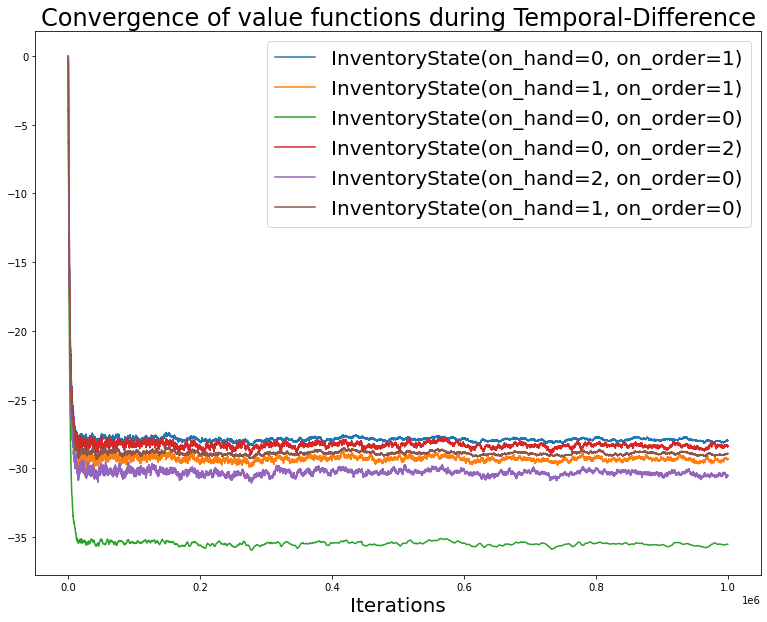

In [80]:
import matplotlib.pyplot as plt
fig,axs = plt.subplots(figsize=(13,10))
axs.set_xlabel('Iterations', fontsize=20)
axs.set_title(f'Convergence of value functions during Temporal-Difference', fontsize=24)
for it in merged_dict.items():
  axs.plot(it[1], label=f'{it[0].state}')
axs.legend(fontsize=20);

Next we visualize the number of visits for each state during the operation of the Monte-Carlo algorithm.

In [81]:
counts_dicts = [(vfa.counts_map) for vfa in vfa_lst]
# counts_dicts

In [82]:
# https://stackoverflow.com/questions/5946236/how-to-merge-dicts-collecting-values-from-matching-keys
from collections import defaultdict
ds = counts_dicts
merged_dict = defaultdict(list)
for d in ds: #input dicts
    for key, value in d.items():
        merged_dict[key].append(value)
# merged_dict

In [83]:
len(merged_dict)

6

/usr/local/lib/python3.7/dist-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


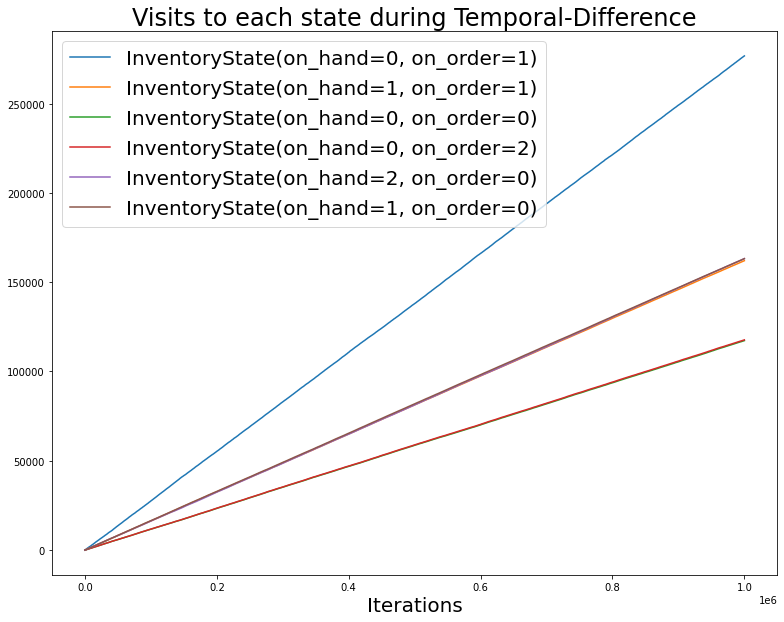

In [84]:
import matplotlib.pyplot as plt
fig,axs = plt.subplots(figsize=(13,10))
axs.set_xlabel('Iterations', fontsize=20)
axs.set_title(f'Visits to each state during Temporal-Difference', fontsize=24)
for it in merged_dict.items():
  axs.plot(it[1], label=f'{it[0].state}')
axs.legend(fontsize=20);

In [ ]:
# hide
# plot_batch: int = 50
# plot_start: int = 0
# learning_rates: Sequence[Tuple[float, float, float]] = \
#     [(0.01, 100000, 0.5), (0.03, 1000, 0.5)]

In [ ]:
# hide
# %%time
# compare_td_and_mc(
#     fmrp=si_mrp,
#     gamma=gamma,
#     mc_episode_length_tol=mc_episode_length_tol,
#     num_episodes=num_episodes,
#     learning_rates=learning_rates,
#     initial_vf_dict=initial_vf_dict,
#     plot_batch=plot_batch,
#     plot_start=plot_start
# )